In [6]:
#Package imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cycler
from math import log10
from scipy import stats
import scipy
from pylab import *
from scipy.optimize import curve_fit
from math import exp, sqrt
from sklearn.linear_model import LinearRegression
from lmfit import Parameters, minimize
import seaborn as sns
from statistics import median

#GAMES imports
import Settings_COVID_Dx
from Solvers_COVID_Dx import calcChi2, calcRsq, solveSingle
from Run_COVID_Dx import addNoise, solveAll, parityPlot
from Saving_COVID_Dx import createFolder

#Define settings

conditions_dictionary, initial_params_dictionary, data_dictionary = Settings_COVID_Dx.init()
full_path = conditions_dictionary["directory"]
model = conditions_dictionary["model"]
data = conditions_dictionary["data"]
error = data_dictionary["error"]
exp_data = data_dictionary["exp_data"]
timecourses_err = data_dictionary["timecourses_err"]
timecourses_exp = data_dictionary["timecourses"]
x = data_dictionary["x_vals"]
df_data = pd.read_pickle('./PROCESSED DATA EXP.pkl')
df_error = pd.read_pickle('./PROCESSED DATA ERR.pkl')  
plt.style.use('./paper.mplstyle.py')
os.chdir(full_path)

In [2]:
def resultsPanel_exp(dfExp, dfErr, labels, varyCondition):   
    '''Purpose: Plot selected readout time courses
    
       Input: 
            dfSim: df containing the simulated data
            dfExp: df containing the experimental data
            dfErr: df containing the measurement error associated with the experimental data
            labels: list of lists containing the condition labels to be plotted
            varyCondition: string contraining the label of the condition that is sweeped over in the plot
   
       Output: none
        
       Plots: MODELING OBJECTIVE ' + str(objective) + '.svg' - 
                Plot of readout dynamics associated with the given modeling objective 
    '''
    
    fig = plt.figure(figsize = (12,3))
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    ax1 = plt.subplot(141)   
    ax2 = plt.subplot(142)

   
    def grabData(labels):
        drop_labels_error = [[5.0, 10.0, 0.001, 1, 90], [1.0, 2.5, 0.001, 10.0, 90.0], [20.0, 10.0, 0.001, 1.0, 90.0], [5.0, 0.5, 0.005, 10.0, 90.0], [20.0, 0.5, 0.005, 1.0, 90.0], [1.0, 2.5, 0.001, 1.0, 90.0], [20.0, 0.5, 0.005, 10.0, 90.0]]
        drop_labels_no_triplicate =[[20.0, 10.0, 0.001, 10.0, 90.0], [20.0, 10.0, 0.001, 0.0, 90.0], [5.0, 2.5, 0.001, 0.0, 90.0]]
        count = 0
    
        maxVal = 0.6599948235700113
        exp =  [1,1,1]
        for (columnName, columnData) in dfExp.iteritems():
            label = list(columnData.iloc[0])
            time = np.linspace(0, 240, 61)
            
       
            if label == labels[0]:
                if label in drop_labels_error or label in drop_labels_no_triplicate:
                    t_course = [0] * 61
                    exp[0] = t_course
                else:
                    t_course = columnData.iloc[1:]
                    exp[0] = [i/maxVal for i in t_course]
            elif label == labels[1]:
                if label in drop_labels_error or label in drop_labels_no_triplicate:
                    t_course = [0] * 61
                    exp[1] = t_course
                else:
                    t_course = columnData.iloc[1:]
                    exp[1] = [i/maxVal for i in t_course]
            elif label == labels[2]:
                if label in drop_labels_error or label in drop_labels_no_triplicate:
                    t_course = [0] * 61
                    exp[2] = t_course
                else:
                    t_course = columnData.iloc[1:]
                    exp[2] = [i/maxVal for i in t_course]
                
        err =  [1,1,1]
        for (columnName, columnData) in dfErr.iteritems():
            label = list(columnData.iloc[0])
            
            time = np.linspace(0, 240, 61)
           
                
            if label == labels[0]:
                if label in drop_labels_error or label in drop_labels_no_triplicate:
                    t_course = [0] * 61
                    err[0] = t_course
                else:
                    t_course = columnData.iloc[1:]
                    err[0] = [i/maxVal for i in t_course]
            elif label == labels[1]:
                if label in drop_labels_error or label in drop_labels_no_triplicate:
                    t_course = [0] * 61
                    err[1] = t_course
                else:
                    t_course = columnData.iloc[1:]
                    err[1] = [i/maxVal for i in t_course]
            elif label == labels[2]:
                if label in drop_labels_error or label in drop_labels_no_triplicate:
                    t_course = [0] * 61
                    err[2] = t_course
                else:
                    t_course = columnData.iloc[1:]
                    err[2] = [i/maxVal for i in t_course]
      
        return exp, err

    if varyCondition == 'T7':
        varyIndex = 0
        vals = [1.0, 5.0, 20.0]
        colors = ['lightgreen', 'mediumseagreen', 'darkgreen']    
    elif varyCondition == 'RT':
        varyIndex = 1
        vals = [0.5, 2.5, 10.0]
        colors = ['lightsteelblue', 'royalblue', 'midnightblue']
    elif varyCondition == 'RNAse':
        varyIndex = 2
        vals = [0.001, 0.005, 0.02]
        colors = ['lightcoral', 'red', 'maroon']
        
    time = np.linspace(0, 240, 61)
    exp1, err1 = grabData(labels)
    for i in range(0, len(exp1)):
        list_exp = exp1[i]
        list_err = err1[i]
        upper_y = []
        lower_y = []
        for j, val in enumerate(list_exp):
            upper_y.append(val + list_err[j])
            lower_y.append(val - list_err[j])

        ax1.fill_between(time, lower_y, upper_y, alpha = .2, color = colors[i])
        ax1.plot(time, exp1[i],  marker = None, linestyle = 'solid', color = colors[i])
        ax1.set_xscale('linear')
    
    ax1.set_xlabel('Time (min)')
    ax1.set_ylabel('Normalized exp output')
    ax1.set_title('vRNA = 1fM', fontsize = 10, fontweight = 'bold')

    for i in range(0, len(labels)):
        labels[i][3] = 10
    
    exp10, err10 = grabData(labels)
        
    for i in range(0, len(exp10)):
        list_exp = exp10[i]
        list_err = err10[i]
        upper_y = []
        lower_y = []
        for j, val in enumerate(list_exp):
            upper_y.append(val + list_err[j])
            lower_y.append(val - list_err[j])

        ax2.fill_between(time, lower_y, upper_y, alpha = .2, color = colors[i])
        ax2.plot(time, exp10[i],  marker = None, linestyle = 'solid', color = colors[i])
        ax2.set_xscale('linear')
    
    ax2.set_xlabel('Time (min)')
   
    ax2.set_title('vRNA = 10fM', fontsize = 10, fontweight = 'bold')
  
    if varyCondition == 'RT':
        objective = 5
    elif varyCondition == 'RNAse':
        objective = 4
    elif varyCondition == 'T7':
        objective = 6
    ax1.set_ylim(0, None)
    ax2.set_ylim(0, None)
    plt.savefig('./MODELING OBJECTIVE ' + str(objective) + ' .svg', dpi = 600, bbox_inches="tight")

In [3]:
#T7 sweep at low RT (0.5)

def sweeps_exp():
    '''Purpose: Plot selected readout time courses for objectives 4, 5, and 6
    
       Input: 
            dfSim: df containing the simulated data
   
       Output: none
        
       Plots: None
    '''
     
    cas = 90
    #labels = [[1.0, 2.5, 0.001, 1, cas], [5.0, 2.5, 0.001, 1, cas], [20.0, 2.5, 0.001, 1, cas]]
    #varyCondition = 'T7'
    #resultsPanel_exp(df_data, df_error, labels, varyCondition) 
    #print('T7 done')

    #labels = [[20.0, 0.5, 0.02, 1, cas], [20.0, 2.5, 0.02, 1, cas], [10.0, 10.0, 0.02, 1, cas]]
    #varyCondition = 'RT'
    #resultsPanel_exp(df_data, df_error, labels, varyCondition) 
    #print('RT done')
    
    labels = [[20.0, 10.0, 0.001, 1, cas], [20.0,  10.0, 0.005,1, cas], [20.0,  10.0, 0.02, 1, cas]]
    varyCondition = 'RNAse'
    resultsPanel_exp(df_data, df_error, labels, varyCondition) 
    #
    #print('RNAse done')
#plotModelingObjectives456()
cas = 90

def RT_sweep(T7_dose, RNase_dose):
    if T7_dose == 'low':
        T7 = 1.0
    elif T7_dose == 'mid':
        T7 = 5.0
    elif T7_dose == 'high':
        T7 = 20.0
        
    if RNase_dose == 'low':
        RNase = 0.001
    elif RNase_dose == 'mid':
        RNase = 0.005
    elif RNase_dose == 'high':
        RNase = 0.02
        
    
    labels = [[T7, 0.5, RNase, 1, cas], [T7, 2.5, RNase, 1, cas], [T7, 10.0, RNase, 1, cas]]
    varyCondition = 'RT'
    resultsPanel_exp(df_data, df_error, labels, varyCondition) 
    
def T7_sweep(RT_dose, RNase_dose):
    if RT_dose == 'low':
        RT = 0.5
    elif RT_dose == 'mid':
        RT = 2.5
    elif RT_dose == 'high':
        RT = 10.0
        
    if RNase_dose == 'low':
        RNase = 0.001
    elif RNase_dose == 'mid':
        RNase = 0.005
    elif RNase_dose == 'high':
        RNase = 0.02
        
    
    labels = [[1.0, RT, RNase, 1, cas], [5.0, RT, RNase, 1, cas], [20.0, RT, RNase, 1, cas]]
    varyCondition = 'T7'
    resultsPanel_exp(df_data, df_error, labels, varyCondition) 
    
def RNase_sweep(RT_dose, T7_dose):
    if RT_dose == 'low':
        RT = 0.5
    elif RT_dose == 'mid':
        RT = 2.5
    elif RT_dose == 'high':
        RT = 10.0
        
    if T7_dose == 'low':
        T7 = 1.0
    elif T7_dose == 'mid':
        T7 = 5.0
    elif T7_dose == 'high':
        T7 = 20.0
        
    labels = [[T7, RT, 0.001, 1, cas], [T7, RT, 0.005, 1, cas], [T7, RT, 0.02, 1, cas]]
    varyCondition = 'RNAse'
    resultsPanel_exp(df_data, df_error, labels, varyCondition) 


## SF16a

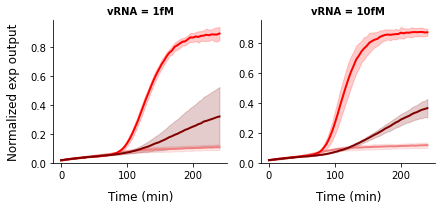

In [4]:
T7_dose = 'low'
RT_dose = 'low'
RNase_sweep(RT_dose, T7_dose)

## SF16b

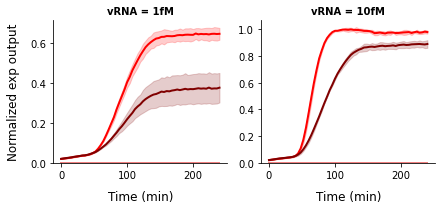

In [7]:
T7_dose = 'low'
RT_dose = 'mid'
RNase_sweep(RT_dose, T7_dose)

## SF16c

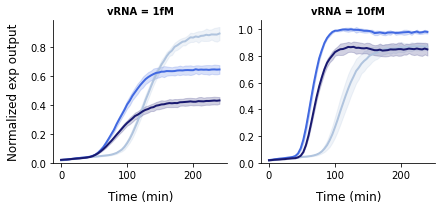

In [8]:
T7_dose = 'low'
RNase_dose = 'mid'
RT_sweep(T7_dose, RNase_dose)  

### Outdated

In [ ]:
T7_dose = 'high'
RNase_dose = 'high'
RT_dose = 'high'
RT_sweep(T7_dose, RNase_dose)  
T7_sweep(RT_dose, RNase_dose)
RNase_sweep(RT_dose, T7_dose)

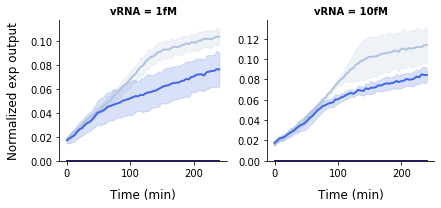

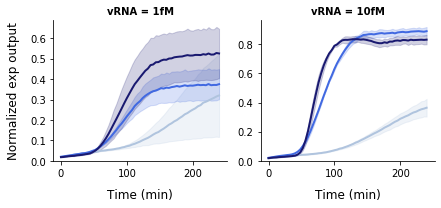

In [4]:
T7_dose = 'high'
RNase_dose = 'low'
RT_sweep(T7_dose, RNase_dose)  

T7_dose = 'low'
RNase_dose = 'high'
RT_sweep(T7_dose, RNase_dose)  



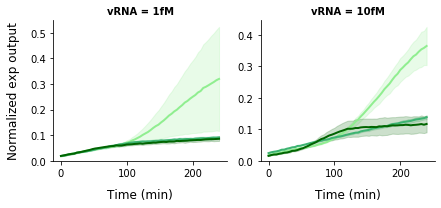

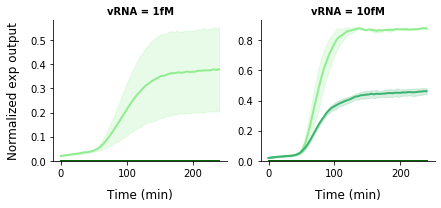

In [5]:
RNase_dose = 'high'
RT_dose = 'low'
T7_sweep(RT_dose, RNase_dose)

RNase_dose = 'low'
RT_dose = 'high'
T7_sweep(RT_dose, RNase_dose)


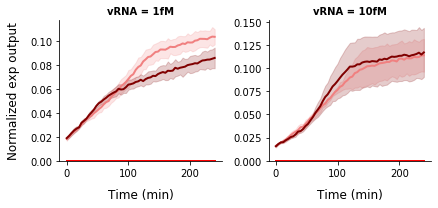

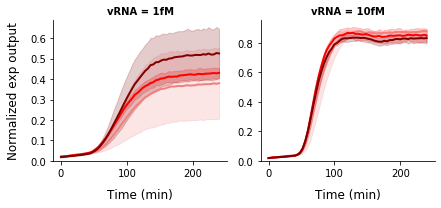

In [6]:
T7_dose = 'high'
RT_dose = 'low'
RNase_sweep(RT_dose, T7_dose)

T7_dose = 'low'
RT_dose = 'high'
RNase_sweep(RT_dose, T7_dose)